# SpikeInterface pipeline for Feldman Lab

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

import spikeextractors as se
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc
import spikewidgets as sw

%matplotlib notebook

## 1a) Load AP recordings, LF recordings and TTL signals

In [2]:
base_path = Path("E:/Feldman/Neuropixels_Feldman/210209/SpikeGLX")
session_name = "LR_210209_g0"

ap_bin_path = base_path / session_name / f"{session_name}_imec0" / f"{session_name}_t0.imec0.ap.bin"
lf_bin_path = base_path / session_name / f"{session_name}_imec0" / f"{session_name}_t0.imec0.lf.bin"
nidq_file_path = base_path / session_name / f"{session_name}_t0.nidq.bin"

# Path to NWBFile, possibly one that already contains behavioral data for the session
nwbfile_path = f"E:/Feldman/{session_name}.nwb"

### Make spikeinterface folders

In [3]:
recording_folder = Path(".")
spikeinterface_folder = recording_folder / "spikeinterface"
spikeinterface_folder.mkdir(parents=True, exist_ok=True)

### (optional) stub recording for fast testing; set to False for running processing pipeline on entire data

In [4]:
stub_test = True
nsec_stub = 30

In [5]:
recording_ap = se.SpikeGLXRecordingExtractor(ap_bin_path)
recording_lf = se.SpikeGLXRecordingExtractor(lf_bin_path)

if stub_test:
    recording_ap = se.SubRecordingExtractor(recording_ap, end_frame=int(nsec_stub*recording_ap.get_sampling_frequency()))
    recording_lf = se.SubRecordingExtractor(recording_lf, end_frame=int(nsec_stub*recording_lf.get_sampling_frequency()))

In [6]:
print(f"Sampling frequency AP: {recording_ap.get_sampling_frequency()}")
print(f"Sampling frequency LF: {recording_lf.get_sampling_frequency()}")      

Sampling frequency AP: 30000.121757
Sampling frequency LF: 2500.010146416667


### Inspect signals

<IPython.core.display.Javascript object>


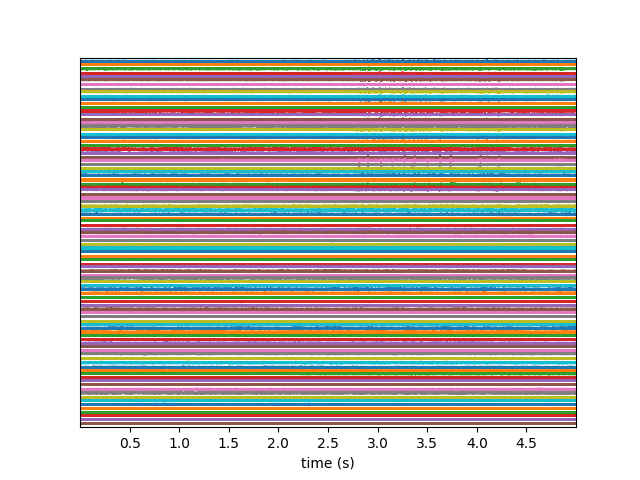

In [7]:
w_ts_ap = sw.plot_timeseries(recording_ap, channel_ids=recording_ap.get_channel_ids()[::4], trange=[0, 5])

<IPython.core.display.Javascript object>


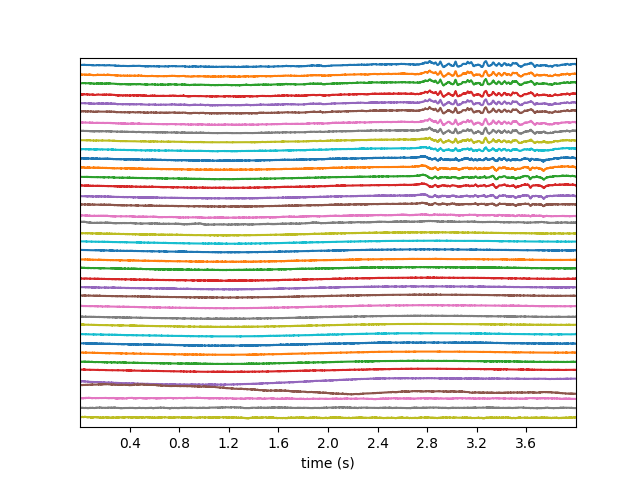

In [20]:
w_ts_lf = sw.plot_timeseries(recording_lf, channel_ids=recording_lf.get_channel_ids()[::10])

## 2) Pre-processing

In [21]:
apply_bandpass = True
apply_cmr = True

In [22]:
if apply_bandpass:
    recording_processed = st.preprocessing.bandpass_filter(recording_ap)
else:
    recording_processed = recording_ap

if apply_cmr:
    recording_processed = st.preprocessing.common_reference(recording_processed)
else:
    recording_processed = recording_processed

In [11]:
num_frames = recording_processed.get_num_frames()

<IPython.core.display.Javascript object>


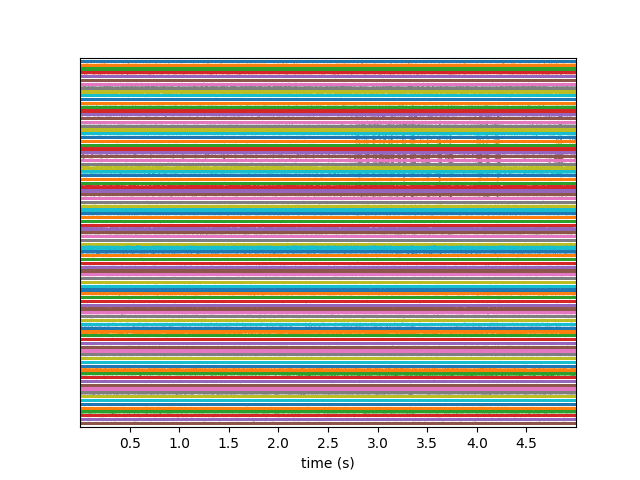

In [12]:
w_ts_ap = sw.plot_timeseries(recording_processed, channel_ids=recording_ap.get_channel_ids()[::4], trange=[0, 5])

In [23]:
rates, amps = st.postprocessing.compute_channel_spiking_activity(
    recording_processed,
    n_jobs=16,
    chunk_mb=4000,
    detect_threshold=8,
    recompute_info=True, 
    verbose=True
)

Number of chunks: 6 - Number of jobs: 16


<IPython.core.display.Javascript object>


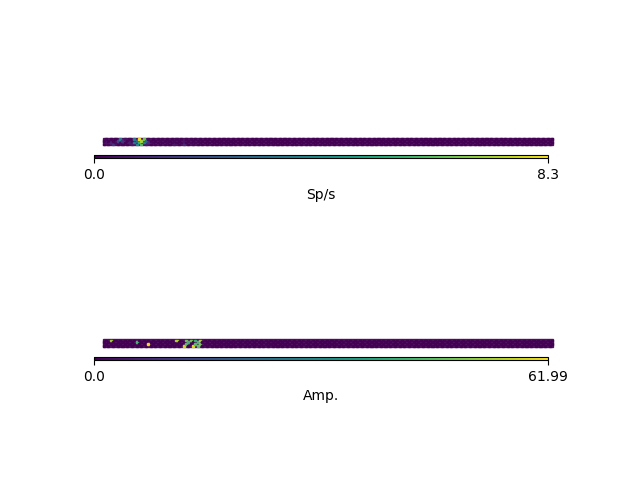

In [68]:
fig, axs = plt.subplots(nrows=2)
sw.plot_activity_map(recording_processed, activity="rate", colorbar=True, ax=axs[0], transpose=True, colorbar_orientation="horizontal")
sw.plot_activity_map(recording_processed, activity="amplitude", colorbar=True, ax=axs[1], transpose=True, colorbar_orientation="horizontal")

## 3) Run spike sorters

In [13]:
sorter_list = [
    # 'tridesclous',
    #'spykingcircus',
    #'herdingspikes',
    #'kilosort2',
    "ironclust"
]

ss.IronClustSorter.set_ironclust_path("D:/GitHub/ironclust")

Setting IRONCLUST_PATH environment variable for subprocess calls to: D:\GitHub\ironclust


In [14]:
# Inspect sorter-specific parameters and defaults
for sorter in sorter_list:
    print(f"{sorter} params description:")
    pprint(ss.get_params_description(sorter))
    print("Default params:")
    pprint(ss.get_default_params(sorter))    

ironclust params description:
{'adjacency_radius': 'Use -1 to include all channels in every neighborhood',
 'adjacency_radius_out': 'Use -1 to include all channels in every neighborhood',
 'batch_sec_drift': 'Batch duration in seconds. clustering time duration',
 'chunk_mb': 'Chunk size in Mb for saving to binary format (default 500Mb)',
 'clip_post': 'Post-peak clip duration in ms',
 'clip_pre': 'Pre-peak clip duration in ms',
 'common_ref_type': 'Common reference type: none, mean, median, trimmean',
 'delta_cut': 'Cluster detection threshold (delta-cutoff)',
 'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the '
                'sign of the spikes in the recording',
 'detect_threshold': 'detection threshold',
 'fGpu': 'Use GPU if True',
 'fParfor': 'Parfor loop',
 'feature_type': 'gpca, pca, vpp, vmin, vminmax, cov, energy, xcov',
 'fft_thresh': 'FFT-based noise peak threshold',
 'fft_thresh_low': 'FFT-based noise peak lower threshold (set to 0 to disable '
 

In [15]:
# user-specific parameters
sorter_params = dict(
    #kilosort2=dict(car=False, n_jobs_bin=12, chunk_mb=4000),
    ironclust=dict(n_jobs_bin=6, chunk_mb=6000),
    #tridesclous=dict(n_jobs_bin=12, chunk_mb=4000),
    #spykingcircus=dict(filter=True, num_workers=16),
    #herdingspikes=dict(filter=True)
)

In [16]:
sorting_outputs = ss.run_sorters(
    sorter_list=sorter_list, 
    recording_dict_or_list=dict(rec0=recording_processed),
    working_folder=spikeinterface_folder / "working1",
    mode="keep", # change to "keep" to avoid repeating the spike sorting
    sorter_params=sorter_params,
    verbose=True,
    run_sorter_kwargs=dict(raise_error=False)
)

Writing to binary .dat file: 100%|#######################################################| 3/3 [01:24<00:00, 28.25s/it]


Warning! The recording is already filtered, but Ironclust filter is enabled. You can disable filters by setting 'filter' parameter to False
Num. channels = 384, Num. timepoints = 900003, duration = 0.499999637384805 minutes
Creating argfile.txt...
Running ironclust in D:\GitHub\feldman-lab-to-nwb\notebooks\spikeinterface\working1\rec0\ironclust\tmp...
RUNNING SHELL SCRIPT: D:\GitHub\feldman-lab-to-nwb\notebooks\spikeinterface\working1\rec0\ironclust\run_ironclust.bat


(base2) D:\GitHub\feldman-lab-to-nwb\notebooks>D:



(base2) D:\GitHub\feldman-lab-to-nwb\notebooks>cd D:\GitHub\feldman-lab-to-nwb\notebooks\spikeinterface\working1\rec0\ironclust\tmp 



(base2) D:\GitHub\feldman-lab-to-nwb\notebooks\spikeinterface\working1\rec0\ironclust\tmp>matlab -nosplash -wait -log -r run_ironclust 


IronClust Version: 2


Removed 0 lock(s).

Running irc2.m (5.9.8)

Created D:\GitHub\feldman-lab-to-nwb\notebooks\spikeinterface\working1\rec0\ironclust\tmp\raw_geom.prm

Read D:\GitHub\feldman-lab-t

In [17]:
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    print(f"{sorter} found {len(sorting.get_unit_ids())} units")
    
    # tridesclous sometimes has empty clusters
    active_units = []
    for u in sorting.get_unit_ids():
        if len(sorting.get_unit_spike_train(u)) > 0:
            active_units.append(u)
    
    if len(active_units) < len(sorting.get_unit_ids()):
        sorting_outputs[result_name] = se.SubSortingExtractor(sorting, unit_ids=active_units)
        print(f"{sorter} found {len(active_units)} units after removing empty")

ironclust found 6 units


## 4) Post-processing: extract waveforms, templates, quality metrics, extracellular features

### Set postprocessing parameters

In [24]:
# Post-processing params
postprocessing_params = st.postprocessing.get_postprocessing_params()
pprint(postprocessing_params)

{'by_electrode': True,
 'compute_property_from_recording': False,
 'dtype': None,
 'frames_after': 3,
 'frames_before': 3,
 'grouping_property': None,
 'joblib_backend': 'loky',
 'max_channels_per_waveforms': None,
 'max_spikes_for_pca': 5000,
 'max_spikes_per_unit': 300,
 'memmap': True,
 'method': 'absolute',
 'ms_after': 3.0,
 'ms_before': 3.0,
 'n_comp': 3,
 'n_jobs': None,
 'peak': 'both',
 'recompute_info': False,
 'save_property_or_features': True,
 'seed': 0,
 'verbose': False,
 'whiten': False}


In [25]:
# (optional) change parameters
postprocessing_params["max_spikes_per_unit"] = 1000  # with None, all waveforms are extracted
postprocessing_params["n_jobs"] = 16  # n jobs
postprocessing_params["chunk_mb"] = 4000  # max RAM usage in Mb
postprocessing_params["verbose"] = True  # max RAM usage in Mb

### Set quality metric list

In [26]:
# Quality metrics
qc_list = st.validation.get_quality_metrics_list()
print(f"Available quality metrics: {qc_list}")

Available quality metrics: ['num_spikes', 'firing_rate', 'presence_ratio', 'isi_violation', 'amplitude_cutoff', 'snr', 'max_drift', 'cumulative_drift', 'silhouette_score', 'isolation_distance', 'l_ratio', 'd_prime', 'noise_overlap', 'nn_hit_rate', 'nn_miss_rate']


In [27]:
# (optional) define subset of qc
qc_list = ["snr", "isi_violation", "firing_rate"]

### Set extracellular features

In [28]:
# Extracellular features
ec_list = st.postprocessing.get_template_features_list()
print(f"Available EC features: {ec_list}")

Available EC features: ['peak_to_valley', 'halfwidth', 'peak_trough_ratio', 'repolarization_slope', 'recovery_slope']


In [29]:
# (optional) define subset of ec
ec_list = ["peak_to_valley", "halfwidth"]

### Postprocess all sorting outputs

In [30]:
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    print(f"Postprocessing recording {rec_name} sorted with {sorter}")
    tmp_folder = spikeinterface_folder / "tmp" / sorter
    tmp_folder.mkdir(parents=True, exist_ok=True)
    
    # set local tmp folder
    sorting.set_tmp_folder(tmp_folder)
    
    # compute waveforms
    waveforms = st.postprocessing.get_unit_waveforms(recording_processed, sorting, **postprocessing_params)
    
    # compute templates
    templates = st.postprocessing.get_unit_templates(recording_processed, sorting, **postprocessing_params)
    
    # comput EC features
    ec = st.postprocessing.compute_unit_template_features(
        recording_processed,
        sorting,
        feature_names=ec_list,
        as_dataframe=True
    )

    # compute QCs
    qc = st.validation.compute_quality_metrics(
        sorting,
        recording=recording_processed, 
        metric_names=qc_list,
        as_dataframe=True
    )
    
    # export to phy
    if sorter == "kilosort2":
        phy_folder = spikeinterface_folder / "phy" / sorter
        phy_folder.mkdir(parents=True, exist_ok=True)
        st.postprocessing.export_to_phy(recording_processed, sorting, phy_folder)

Postprocessing recording rec0 sorted with ironclust
Number of chunks: 6 - Number of jobs: 16


<IPython.core.display.Javascript object>


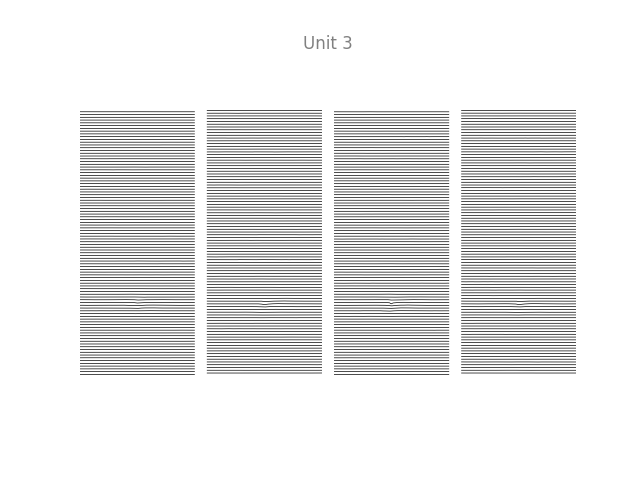

In [69]:
sorting_ic = sorting_outputs[("rec0", "ironclust")]
w = sw.plot_unit_templates(
    recording_processed,
    sorting_ic,
    unit_ids=[3],
    radius=None,  # This is spatial distance specifying channels around the unit
    lw=0.5
)
#w.figure.set_size_inches((5,15))

### Run phy and load curated data

In [ ]:
!phy template-gui spikeinterface/phy/kilosort2/params.py

In [ ]:
sorting_manual_curated = se.PhySortingExtractor(phy_folder, exclude_cluster_groups=["noise"])

In [ ]:
print(f"Kilosort2 found {len(sorting_manual_curated.get_unit_ids())} units after manual curation")

## 5) Ensemble spike sorting

In [ ]:
if len(sorting_outputs) > 1:
    # retrieve sortings and sorter names
    sorting_list = []
    sorter_names_comp = []
    for result_name, sorting in sorting_outputs.items():
        rec_name, sorter = result_name
        sorting_list.append(sorting)
        sorter_names_comp.append(sorter)
        
    # run multisorting comparison
    mcmp = sc.compare_multiple_sorters(sorting_list=sorting_list, name_list=sorter_names_comp)
    
    # plot agreement results
    w_agr = sw.plot_multicomp_agreement(mcmp)
    
    # extract ensamble sorting
    sorting_ensemble = mcmp.get_agreement_sorting(minimum_agreement_count=2)
    
    print(f"Ensemble sorting among {sorter_list} found: {len(sorting_ensemble.get_unit_ids())} units")

In [ ]:
sw.plot_rasters(sorting_ensemble)

# 6) Automatic curation

In [ ]:
# define curators and thresholds
firing_rate_threshold = 0.1 # Hz
isi_violation_threshold = 0.5 # s
snr_threshold = 5

In [ ]:
sorting_auto_curated = []
sorter_names_curation = []
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    sorter_names_curation.append(sorter)
    
    # firing rate threshold
    sorting_curated = st.curation.threshold_firing_rates(
        sorting,
        duration_in_frames=num_frames,
        threshold=firing_rate_threshold, 
        threshold_sign="less"
    )
    
    # isi violation threshold
    sorting_curated = st.curation.threshold_isi_violations(
        sorting_curated,
        duration_in_frames=num_frames,
        threshold=isi_violation_threshold, 
        threshold_sign="greater"
    )
    
    # isi violation threshold
    sorting_curated = st.curation.threshold_snrs(
        sorting_curated,
        recording=recording_processed,
        threshold=snr_threshold, 
        threshold_sign="less"
    )
    sorting_auto_curated.append(sorting_curated)
    print(f"{sorter} found {len(sorting_curated.get_unit_ids())} units after auto curation")

# 7) Save to NWB; writes only the spikes

In [ ]:
# Choose the sorting extractor from the notebook environment you would like to write to NWB
chosen_sorting_extractor = sorting_outputs[("rec0", "ironclust")]

se.NwbSortingExtractor.write_sorting(
    sorting=chosen_sorting_extractor,
    save_path=nwbfile_path,
    overwrite=False,  # this appends the file. True would write a new file
    skip_features=["waveforms"]
)